In [712]:
#import libraries
from Bio import SeqIO
from scipy.stats import fisher_exact
import pandas as pd
import copy
import json
import gzip
import requests
import sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func



In [713]:
# Loading DO ontology obo file and anazlyzing the architecture
Doid_obo = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/doid.obo"
with open(Doid_obo) as ontology:
    labels, ancestors, min_depth = disease_ontology(ontology)

In [714]:
#loading uniprot_do dataset with associated terms
Do_Uniprot = 'C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets//uniprot_do.json'
with open(Do_Uniprot) as file:
    uniprot_protein = json.load(file)


In [715]:
def disease_ontology(ontology):
     # dictionary with do ids and their objects
    do = {} 
    obj = {}
    # obj:  { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True } 
    for line in ontology:
        line = line.strip().split(": ")
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}
        
    # For each node, we make the dictionary of ancestors and the depth
    tag, anc, depth = ancestors_dict(do)
    
    return tag, anc, depth


In [716]:
def ancestors_dict(do):
    
    #Finding ancestors and depth for each node and storing the values in seperate dictionaries
    
    ancestors = {}  #  term : set of all ancestors
    parents = {}
    depth = {}
    labels = {}
    for node in do:
        c = 0
        node_ancestors = []
        node_parents = do[node].get("is_a")
        labels[node] = do[node].get("name")
        if node_parents != None:
            parents[node] = node_parents
        else:
            parents[node] = []
            
        while node_parents:
            c += 1
            node_ancestors.extend(node_parents)
            if "4" in node_parents:  
                depth[node] = c
            node_parents = [term for parent in node_parents for term in do[parent].get("is_a", [])]
        ancestors[node] = set(node_ancestors)
    
    
    depth = find_min_depth(list(do.keys()), parents)
     
    return labels, ancestors, depth

In [717]:
def find_min_depth(nodes, parents):   
    
    #Calculating the minimum depth of each term i.e for each term calculate its distance from the root
    
    depth = {} 
    roots = set(nodes) - set(parents.keys())
    for node in nodes:
        c = 0   
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            if roots.intersection(set(node_parents)):  
                break
            
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth


In [718]:
def do_fisher_test(ds_c, bg_c, depth, l):
    
    #running fisher's test to find pvalue for enrichment
    
    results = {}  #dictionary for final results { Oddratio, pvalue }
    
    # Get the total number of values
    total_d = sum(list(ds_c.values()))
    total_bg = sum(list(bg_c.values()))
    
    #find the same keys in both datasets
    key_intersection = set(ds_c.keys()).intersection(set(bg_c.keys()))
    
    for key in key_intersection:
        # Count of similar do terms in the main dataset
        x = ds_c[key]
        
        # Count of the similar do terms in background dataset
        y = bg_c[key]
        
        # Count of do terms that are different from the same ones in ds_c
        not_x = total_d - x
        
        # Count of do terms that are different from the same ones in bg_c
        not_y = total_bg - y
        
        # Perform Fisher Exact Test
        fisher_stats = fisher_exact([[x, y],[not_x, not_y]])
        
        # save results in a dictionary
        results.setdefault(key, {'OddRatio': fisher_stats[0], 'pvalue': fisher_stats[1]})
    
    
    # return dataframe of results
    return pd.DataFrame(results).transpose()

In [719]:
def depth_details(df, min_depth, labels):
    
    #Add columns for depth and description in results 
    
    l_list= []   
    depth_list = []
    for key in df.index:             # for all the keys in dataframe, associate label and depth values
        l_list.append(labels[key])
        depth_list.append(min_depth[key])
    
    df['depth'] = depth_list        #add depth column in dataframe
    df['label'] = l_list            #add label column in dataframe

    return df

In [720]:
def draw_word_cloud(df, score='OddRatio', N=20, N_under_represented=0, under_represented=False, scale=2.0):
    df_wcloud= df[:N]
    wcloud = WordCloud(background_color='black', width=2000, max_words=80, collocations=False,height=800)
    wcloud.generate_from_frequencies({line['label']: line[score] for _, line in df_wcloud.iterrows()})
    return wcloud


In [721]:
def count_ancestors(protein_list, ancestors, uni_protein):
    
    #Count the number of ancestors for a list of proteins
    counts = {}

    # finding the intersection between dataset and uniprot_protein keys
   
    for protein in set(protein_list).intersection(set(uni_protein.keys())):
        annotations = set(uni_protein[protein])
        terms_ancestors = copy.copy(annotations)  # annotations and ancestor terms
        
        for z in annotations:  # directly annotated terms
            terms_ancestors.update(set(ancestors.get(z, [])))  # add ancestors
            
        for z in terms_ancestors:
            counts.setdefault(z, 0)
            counts[z] += 1
        
    return counts

### A: ORIGINAL DATASET VS SWISSPROT HUMAN PROTEOME

In [722]:
#load original dataset
Original = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/Original_dataset5.txt"
with open(Original) as f:
    dataset = f.read().splitlines()

In [723]:
#load background dataset: entire human proteome available in SwissProt.
human = SeqIO.parse('C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/uniprot-reviewed_Homo_sapiens.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id 
    background.append(name.split('|')[1])

#### Calculate Statistics

In [724]:
# perform fisher exact test
dataset_c = count_ancestors(dataset, ancestors,uniprot_protein)
background_c = count_ancestors(background, ancestors, uniprot_protein)

result = do_fisher_test(dataset_c, background_c, min_depth, labels)
result.sort_values(by = "OddRatio", ascending=False, inplace=True)

result.head()

,OddRatio,pvalue
2247,310.846821,0.006412
0080010,310.846821,0.006412
0080325,103.614644,0.012784
4990,77.710621,0.015954
0050678,62.168208,0.019114


In [725]:
# add depth and description columns
frame = depth_details(df = result,min_depth = min_depth, labels = labels)
frame.head()

,OddRatio,pvalue,depth,label
2247,310.846821,0.006412,7,spondylosis
0080010,310.846821,0.006412,6,bone structure disease
0080325,103.614644,0.012784,6,tuberous sclerosis 2
4990,77.710621,0.015954,6,essential tremor
0050678,62.168208,0.019114,5,Blau syndrome


In [726]:
# filter all the results by depth and alpha
alpha=0.05
filter_terms = (frame["depth"] <= 5) & (frame["pvalue"] <= alpha)
frame[filter_terms].head()

,OddRatio,pvalue,depth,label
0050678,62.168208,0.019114,5,Blau syndrome
0050855,23.909960,0.044033,4,renal fibrosis
0050830,4.797298,0.010827,5,peripheral artery disease
3393,4.299282,0.007109,5,coronary artery disease
0050828,2.459944,0.039048,4,artery disease


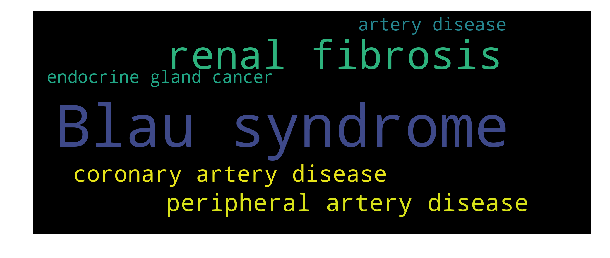

In [727]:
N = 50
word_cloud = draw_word_cloud(df = frame[filter_terms],N = N,score = 'OddRatio')
plt.figure(figsize=(10, 10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### B: Architectures datasets - The original dataset

In [728]:
# load file containing architectures datasets
with open("C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/architecture_datasets.json") as f:
    arch_dataset = json.load(f)

In [729]:
#load original file as background dataset
Original = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/Original_dataset5.txt"
with open(Original) as f:
    dataset = f.read().splitlines()

In [730]:
background_c = count_ancestors(dataset, ancestors, uniprot_protein)

In [731]:
# we take datasets containing at least 2 sequences
MIN_SIZE = 2 

results = {}
filtered_results = {}

for key in arch_dataset:
    
    current_dataset = arch_dataset[key]
    
    if len(current_dataset) >= MIN_SIZE:
        dataset_c = count_ancestors(current_dataset, ancestors, uniprot_protein)

        # call fisher's exact test
        result_fisher = do_fisher_test(dataset_c, background_c, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        result = depth_details(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )
        results[key] = result
        
        # filter by alpha
        alpha = 0.1
        filter_terms = (result["pvalue"] <= alpha)
        filtered_results[key] = result[filter_terms]

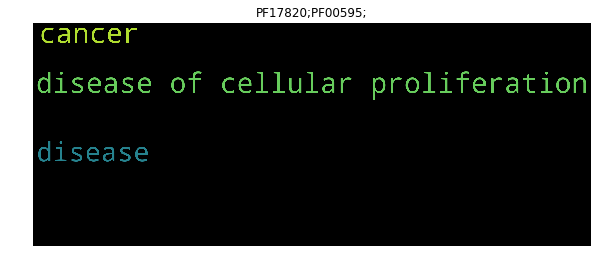

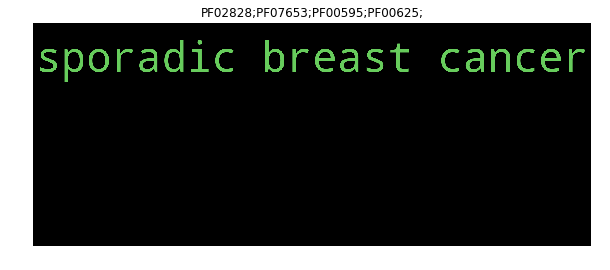

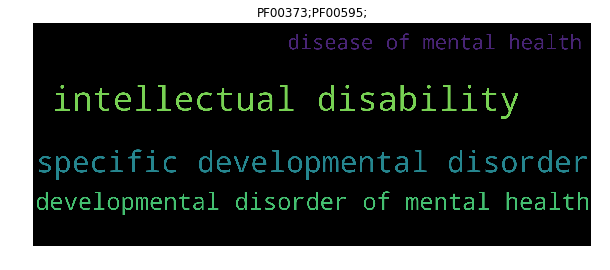

In [732]:
# draw wordcloud
for key in filtered_results:  
    if filtered_results[key].shape[0] > 0:
        word_c= draw_word_cloud(df = filtered_results[key],score = 'OddRatio')
        plt.figure(figsize=(10,10))
        plt.title(key)
        plt.imshow(word_c)
        plt.axis("off")
        plt.show()
        

### C: PDB network - All human PDB proteins available in SwissProt (intersection)

In [733]:
#load PDB file
PDB_PATH= "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/PDB_dataset.txt"
dataset_df = pd.read_csv(PDB_PATH,header=None,names=["sp_primary"])

# make dataset for unique proteins
dataset = dataset_df.sp_primary.unique()

In [734]:
# dataset with human sequences in swissprot
human_dataset_path = 'C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/uniprot-reviewed_Homo_sapiens.fasta'

#### Create background dataframe, all PDB proteins in swissprot

In [735]:
def getListHumans(path):
    human_dataset = SeqIO.parse(path, 'fasta')
    list_human = []
    for sequence in human_dataset:
        name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
        list_human.append(name.split('|')[1])
    return list_human

In [736]:
#get list of human sequences in swissprot
list_human = getListHumans(human_dataset_path)

In [737]:
#Import pdb - uniprot relation file
PDB_UNIPROT = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/pdb_chain_uniprot_5.csv"
pdb_uni = pd.read_csv(PDB_UNIPROT,header=0)
pdb_uni=pd.DataFrame(pdb_rel)

#convert column names into smaller letters
pdb_uni.columns = list(map(lambda x: x.lower(), pdb_uni.columns.values))
pdb_uni.head()


,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40


In [738]:
#find similar values in both datasets to create intersection
pdb_bg = pdb_uni.loc[pdb_uni.sp_primary.isin(list_human),['pdb','sp_primary','chain','sp_beg','sp_end']].copy()
bg_dataset = pdb_bg.sp_primary.unique()
print(len(bg_dataset))

6742


#### Calculate Statistics

In [739]:
# count the anchestors for each sequence of the dataset
dataset_c = count_ancestors(dataset, ancestors, uniprot_protein)
background_c = count_ancestors(bg_dataset, ancestors, uniprot_protein)

In [740]:
result_fisher = do_fisher_test(dataset_c, background_c, min_depth, labels)
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)
result = depth_details(df = result_fisher,min_depth = min_depth, labels = labels)
result.head()

,OddRatio,pvalue,depth,label
0080010,97.866412,0.020146,6,bone structure disease
2059,97.866412,0.020146,4,vulvar disease
1294,97.866412,0.020146,7,vulva carcinoma
0080366,97.866412,0.020146,6,desmoid tumor
1245,97.866412,0.020146,6,vulva cancer


In [741]:
# filter by depth and pvalue
filter_terms = (result["depth"] <= 5) & (result["pvalue"] <= 0.05)
result[filter_terms].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2059 to 225
Data columns (total 4 columns):
OddRatio    17 non-null float64
pvalue      17 non-null float64
depth       17 non-null int64
label       17 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 680.0+ bytes


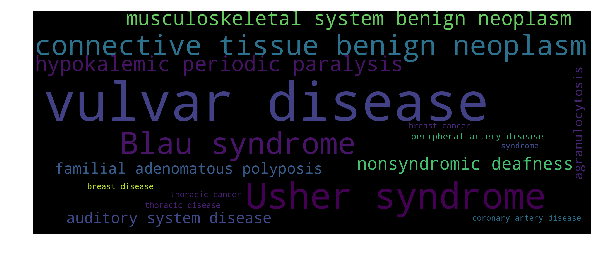

In [742]:
# Num of words to be drawn
N = 20
word_c = draw_word_cloud(df = result[filter_terms],N = N, score = 'OddRatio')
plt.figure(figsize=(10, 10))
plt.imshow(word_c)
plt.axis("off")
plt.show()

### D: STRING network - All human proteins available in STRING and SwissProt (intersection)

In [743]:
# read the STRING dataset 
with open("C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/NEW_STRING_dataset.txt") as f:
    dataset = f.read().splitlines()
print(len(dataset))

437


In [744]:
# Get Background dataset from uniprot
import requests
URL = "https://www.uniprot.org"
# Get human proteins available in STRING and Swissprot
query = "database:(type:string) AND reviewed:yes AND organism:\"Homo sapiens (Human) [9606]\"&format=list"
bg = requests.get("{}/uniprot/?query={}".format(URL, query))

In [745]:
bg_dataset = bg.text.strip().split("\n")
print(len(bg_dataset))

18561


In [746]:
# count the anchestors for each sequence of the dataset
dataset_c = count_ancestors(dataset, ancestors, uniprot_protein)
background_c = count_ancestors(bg_dataset, ancestors, uniprot_protein)
result_fisher = do_fisher_test(dataset_c, background_c, min_depth, labels)
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

# add depth and description columns
result = depth_details(df = result_fisher,min_depth = min_depth, labels = labels)
result.head()

,OddRatio,pvalue,depth,label
0050678,28.735892,0.000009,5,Blau syndrome
13619,28.724157,0.006493,7,extrahepatic cholestasis
0060082,28.720248,0.066171,5,breast benign neoplasm
4556,28.720248,0.066171,8,lung large cell carcinoma
0110368,28.720248,0.066171,9,retinitis pigmentosa 26


In [747]:
# filter by depth
filter_terms = (result["depth"] <= 6) & (result_fisher["pvalue"] <= 0.05)
result[filter_terms].info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0050678 to 0050460
Data columns (total 4 columns):
OddRatio    78 non-null float64
pvalue      78 non-null float64
depth       78 non-null int64
label       78 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ KB


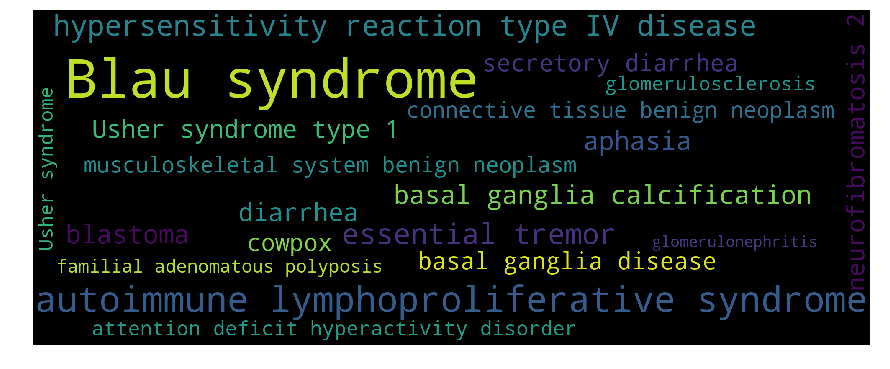

In [748]:
N_max = 50
word_c=draw_word_cloud(df = result[filter_terms],N = N,score = 'OddRatio',scale = 1,)
plt.figure(figsize=(15,15))
plt.imshow(word_c)
plt.axis("off")
plt.show()